# BERT EN Model

### This notebook contains the implementation of the BERT model pre-trained on the english language set coming from `Datasets/BERT/train_en.csv`

### The following steps are taken to establish the model
- **Data exploration and visualization**
- **Model definition**
- **Optimizer algorithm selection**
- **Loss function selection**
- **Training loop**
- **Model saving**

In [1]:
!pip install -q keras-nlp --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 76.1 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
import keras_nlp
import keras
import tensorflow

keras.mixed_precision.set_global_policy("mixed_float16")

#### Data Exploration and Visualization

In [7]:
bert_en_dataset = pandas.read_csv("train_en.csv")
bert_en_dataset.head()

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,label_name
0,0,a937bd90a8,"3) Dare you rise to the occasion, like Raskol...",Would you rise up and defeaat all evil lords i...,en,English,1,neutral
1,1,0abb9434d5,"He married Dona Filipa Moniz (Perestrelo), the...",He landed on the island but soon left for gree...,en,English,2,contradiction
2,2,bc52edfd5b,The contrast between the landscape of the cent...,There was a beautiful artist who painted the l...,en,English,1,neutral
3,3,62344708db,i don't know i i do i can think of all the uh ...,I know this because I own a bible.,en,English,1,neutral
4,4,03f3c9a92e,'So I assume he hacked into the autopilot and ...,I'm assuming he hacked the autopilot to bring ...,en,English,1,neutral


##### Validation to ensure the data is clean when being passed to the model

In [ ]:
bert_en_dataset.isna().sum()

,0
Unnamed: 0,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0
label_name,0


In [ ]:
(bert_en_dataset.lang_abv != "en").sum()

0

In [ ]:
bert_en_dataset.label[~bert_en_dataset.label.isin([0, 1, 2])].any()

False

##### Descriptions and summaries of data

In [ ]:
bert_en_dataset.id.count()

3435

- A fairly small dataset relatively speaking to other sources.

In [ ]:
bert_en_dataset.hypothesis.describe()

,hypothesis
count,3435
unique,3435
top,Did you do it?
freq,1


In [ ]:
for i in range(10):
    print(bert_en_dataset.hypothesis[i])

Would you rise up and defeaat all evil lords in the town?
He landed on the island but soon left for greener pastures, before later dying alone and childless.
There was a beautiful artist who painted the landscape of the central highlands.
I know this because I own a bible.
I'm assuming he hacked the autopilot to bring the plane down.
They would make pilgrimages to Jerusalem.
A traveler said the settlement was prospering. 
TIG funds are used to support the Technology Evolution project, a legal aid society in Cincinnati. 
I could not agree with you.
You were thought to be dead!


- All hypothesis are unique and follow the structure shown above. The premises that follow may either directly follow from the hypothesis, contradict it or not contain enough information to make a proper conclusion.

In [ ]:
bert_en_dataset.premise.describe()

,premise
count,3435
unique,2380
top,We are also advocating enhanced reporting in c...
freq,3


In [ ]:
for i in range(10):
    print(bert_en_dataset.premise[i])

3)  Dare you rise to the occasion, like Raskolnikov, and reject the petty rules that govern lesser men?
He married Dona Filipa Moniz (Perestrelo), the daughter of Porto Santo's first governor, and lived on the island for a period, fathering a son there.
The contrast between the landscape of the central highlands and the south coast could not be more marked.
i don't know i i do i can think of all the uh the biblical things about it too where what did they say to uh i can't think of the scripture Render unto Caesar's what is Caesar's so
'So I assume he hacked into the autopilot and reprogrammed it to-'
They returned to live in the Galilee village of Nazareth, making pilgrimages to Jerusalem.
An Indian traveler described the prosperous Bujang Valley settlement as  the seat of all felicities.  
TIG funds support the Technology Evaluation Project, an initiative of the Legal Aid Society of Cincinnati.
well i think i got to agree with you there
Say, man, don't you know you've been given up fo

- **Note:** Not all the premises that follow **are necessarily unique.** This is done to have the model be able to **recognize several conclusions that may be drawn from a hypothesis.**

In [ ]:
bert_en_dataset.label.describe()

,label
count,3435.000000
mean,0.984862
std,0.823577
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


- From the five-number summary, it can be surmised that most of the data seems to contain neutral conclusions in the premises. This likely suggests that the model will need to learn and encode finer details in the premises to draw accurate conclusions and predictions.

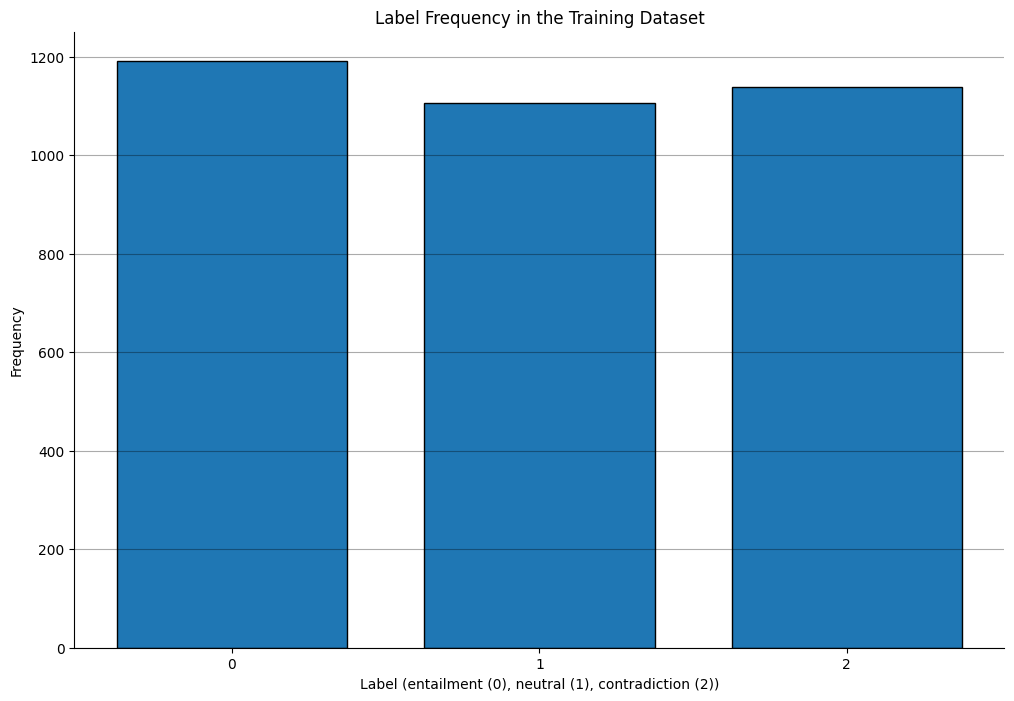

In [ ]:
labels = bert_en_dataset.label.to_numpy()

plt.figure(figsize=(12, 8))

plt.hist(labels, bins=range(4), align="left", rwidth=0.75, edgecolor="black")

plt.xticks(numpy.arange(3))

for pos in ["top", "right"]:
    plt.gca().spines[pos].set_visible(False)

plt.grid(axis="y", alpha=0.33, color="black")

plt.xlabel("Label (entailment (0), neutral (1), contradiction (2))")

plt.ylabel("Frequency")

plt.title("Label Frequency in the Training Dataset")

plt.show()

- From the historgram above, it seams that the most frequent premise is an entailment, while a neutral conclusion happens the least.

In [ ]:
def get_length_of_text(_text):
    return len(_text)


length_of_hypothesis_texts = bert_en_dataset.hypothesis.apply(get_length_of_text)

length_of_premise_texts = bert_en_dataset.premise.apply(get_length_of_text)

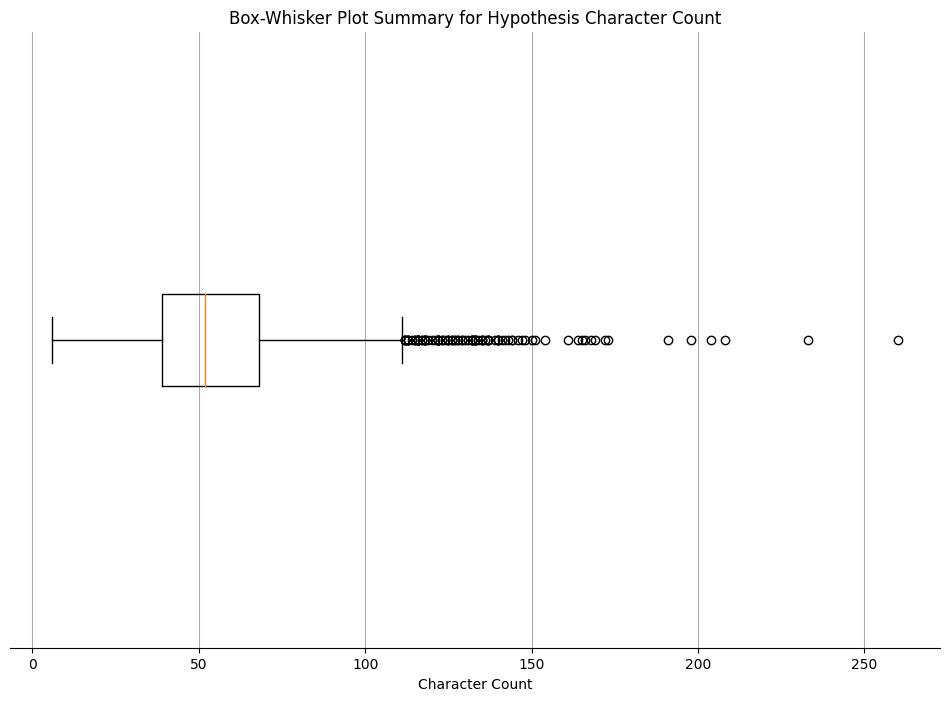

In [ ]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_hypothesis_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Hypothesis Character Count")

plt.show()

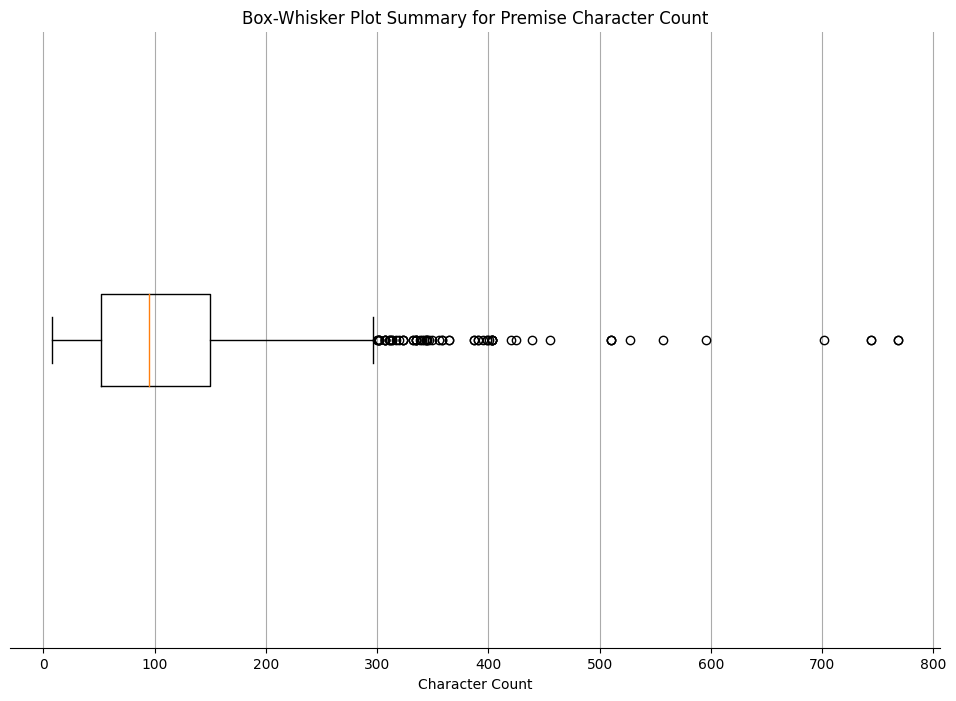

In [ ]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_premise_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Premise Character Count")

plt.show()

- From the summary plots of the character counts in the texts, it can be seen that there appear to be many outliers in the distribution. This means that there exists several text elements that are much longer than upper limits of the distribution. This may affect the encoding of the textual embeddings in the model.

- Otherwise, it would seem on average that the premises are longer than the hypotheses.

#### Model Definition

In [3]:
def split_labels(x, y):
    return (x[0], x[1]), y

In [8]:
batch_size = 128

VALIDATION_SPLIT = 0.2
TRAIN_SIZE = int(bert_en_dataset.shape[0] * (1-VALIDATION_SPLIT))

training_dataset = (
    tensorflow.data.Dataset.from_tensor_slices(
        (
            bert_en_dataset[["hypothesis", "premise"]].values,
            bert_en_dataset["label"].values
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)

In [ ]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en", sequence_length=512)

def get_max_token_length(dataset, preprocessor):
  token_lengths = []

  for hypothesis, premise in dataset[["hypothesis", "premise"]].values:

    encoded = preprocessor([hypothesis, premise])
    encoded_np = encoded["padding_mask" ]. numpy()
    non_padding_count = encoded_np.sum()
    token_lengths.append(non_padding_count)

  return max(token_lengths)

max_token_length = get_max_token_length(bert_en_dataset, preprocessor)

print(f"Maximum token length in the dataset: {max_token_length}")

100%|██████████| 508/508 [00:00<00:00, 496kB/s]


100%|██████████| 547/547 [00:00<00:00, 638kB/s]


100%|██████████| 226k/226k [00:00<00:00, 290kB/s]


Maximum token length in the dataset: 188


In [ ]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en", sequence_length=195)

bert_train_set = (train_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

bert_val_set = (val_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_en", preprocessor=None, num_classes=3)
history = classifier.fit(bert_train_set, validation_data=bert_val_set, epochs=3)

100%|██████████| 110M/110M [00:08<00:00, 13.6MB/s]


Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 436ms/step - loss: 1.1024 - sparse_categorical_accuracy: 0.3519 - val_loss: 1.0648 - val_sparse_categorical_accuracy: 0.4297
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - loss: 1.0254 - sparse_categorical_accuracy: 0.4830 - val_loss: 0.9992 - val_sparse_categorical_accuracy: 0.4969
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - loss: 0.8973 - sparse_categorical_accuracy: 0.5971 - val_loss: 0.9599 - val_sparse_categorical_accuracy: 0.5594


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [ ]:
print(history_dict["val_loss"])
print(history_dict["val_sparse_categorical_accuracy"])

[1.0647891759872437, 0.9992058873176575, 0.959933876991272]
[0.4296875, 0.49687498807907104, 0.559374988079071]


- With this first testing, we have our basis for creating a model capable of training itself to fit the dataset and improve it's accuracy over multiple epochs. From now, we must fine tune the model by changing it's different training hyperparameters, defining it's base optimization procedure and defining what loss and accuracy metrics we will use.

### Optimization algorithm and loss function selection

- For any future testing, the adam optimization algorithm will be the default for all training tests and the same will be applied to the loss function of categorical cross entropy. For any additional metrics to be specified, normal accuracy will be used for the training and validation verification

### Additional codes or implementations

- To further get a better understanding of the training process, a callback object will be implemented inside the model's training procedure to get all loss calculations per batch instead of only keeping per epoch losses as the base fit method does.

In [4]:
class BCP(keras.callbacks.Callback):
    batch_accuracy = []
    batch_loss = []
    def __init__(self):
        super(BCP,self).__init__()
    def on_train_batch_end(self, batch, logs=None):
        BCP.batch_accuracy.append(logs.get('accuracy'))
        BCP.batch_loss.append(logs.get('loss'))

### Training loops and hyperparameter random searching

- First base test applying previous definitions of optimization, loss and callback testing before moving on to randomized searching

In [ ]:
batch_size = 128

train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)

preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en", sequence_length=195)

bert_train_set = (train_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

bert_val_set = (val_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_en", preprocessor=None, num_classes=3)

classifier.compile(optimizer=keras.optimizers.Adam(1e-5), metrics=['accuracy'])
callback = BCP()
BCP.batch_accuracy = []
BCP.batch_loss = []
history = classifier.fit(bert_train_set, validation_data=bert_val_set, epochs=5, callbacks=[callback]);

Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 431ms/step - accuracy: 0.3398 - loss: 1.1428 - val_accuracy: 0.3047 - val_loss: 1.1192
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.3456 - loss: 1.1028 - val_accuracy: 0.3422 - val_loss: 1.1035
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 0.3968 - loss: 1.0821 - val_accuracy: 0.3828 - val_loss: 1.0951
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.4427 - loss: 1.0711 - val_accuracy: 0.4125 - val_loss: 1.0851
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.4644 - loss: 1.0573 - val_accuracy: 0.4328 - val_loss: 1.0735


In [ ]:
print(BCP.batch_accuracy)
print(BCP.batch_loss)

[0.3515625, 0.34765625, 0.3541666865348816, 0.37109375, 0.3515625, 0.3450520932674408, 0.3470982313156128, 0.3466796875, 0.3463541567325592, 0.3460937440395355, 0.34446024894714355, 0.34375, 0.3383413553237915, 0.3364955484867096, 0.3317708373069763, 0.32861328125, 0.32996323704719543, 0.328125, 0.3252467215061188, 0.32148438692092896, 0.3203125, 0.3125, 0.32421875, 0.3489583432674408, 0.341796875, 0.3453125059604645, 0.3528645932674408, 0.3504464328289032, 0.35546875, 0.3567708432674408, 0.3570312559604645, 0.34872159361839294, 0.35546875, 0.356370210647583, 0.3493303656578064, 0.3447916805744171, 0.34326171875, 0.34191176295280457, 0.3424479067325592, 0.34210526943206787, 0.341796875, 0.3463541865348816, 0.390625, 0.35546875, 0.3984375, 0.388671875, 0.3890624940395355, 0.3802083432674408, 0.3750000298023224, 0.3857421875, 0.3975694477558136, 0.4000000059604645, 0.40127840638160706, 0.4088541865348816, 0.4092548191547394, 0.4101562798023224, 0.4098958671092987, 0.40673828125, 0.405330

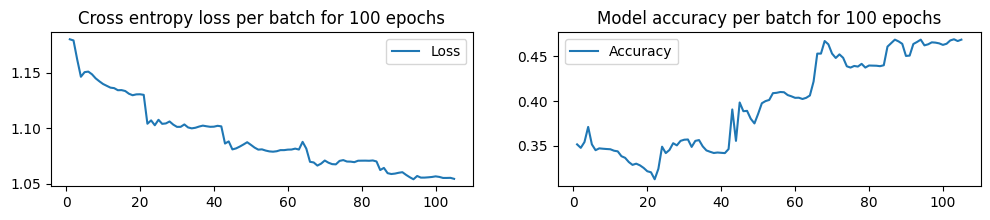

In [ ]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
ax1.plot(np.arange(1,len(callback.batch_loss)+1), BCP.batch_loss, label="Loss")
ax1.set_title("Cross entropy loss per batch for 100 epochs")
ax1.legend()
ax2.plot(np.arange(1,len(BCP.batch_accuracy)+1), BCP.batch_accuracy, label="Accuracy")
ax2.set_title("Model accuracy per batch for 100 epochs")
ax2.legend()

- Implementing the random search

For the selectable paramaters  
batch size: anywhere from 8 to 250  
adam learning rate: [0.1, 0.01, 0.001, 0.0001, 0.00001]

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 463ms/step - accuracy: 0.3340 - loss: 1.8569 - val_accuracy: 0.3812 - val_loss: 1.2573
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.3410 - loss: 1.2209 - val_accuracy: 0.3812 - val_loss: 1.2016
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.3700 - loss: 1.2280 - val_accuracy: 0.3812 - val_loss: 1.2694
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.3491 - loss: 1.2417 - val_accuracy: 0.3812 - val_loss: 1.2695
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.3483 - loss: 1.2068 - val_accuracy: 0.3812 - val_loss: 1.2115
Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3598 - loss: 1.1122 - val_accuracy: 0.3902 - val_loss: 1.0967
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - accuracy: 0.3643 - loss: 1.0987 - val_accuracy: 0.3794 - val_loss: 1.0958
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - accuracy: 0.3759 - loss: 1.1029 - val_accuracy: 0.3856 - v

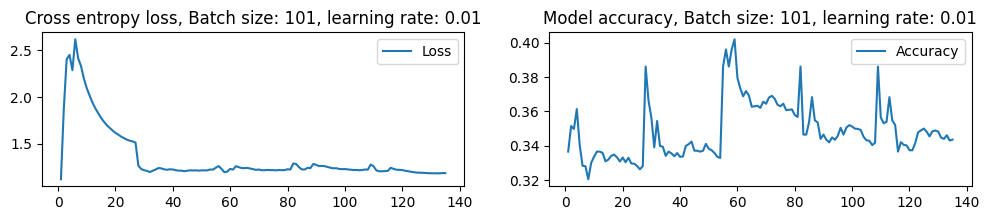

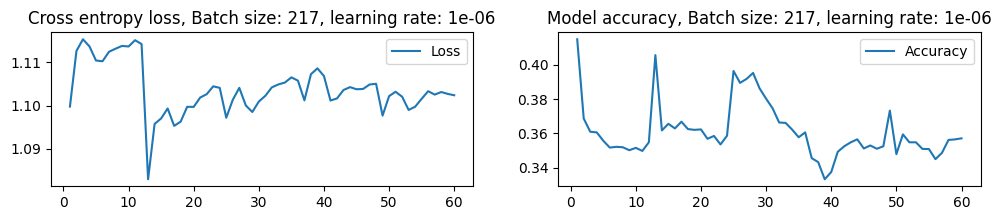

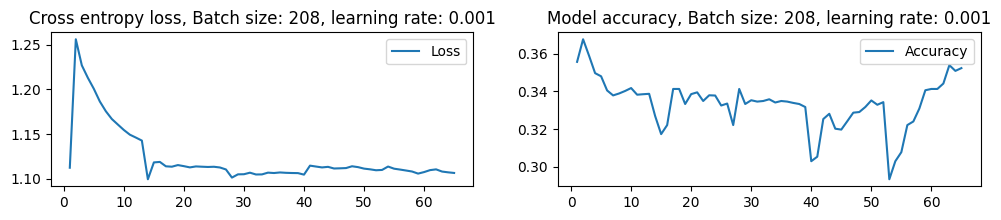

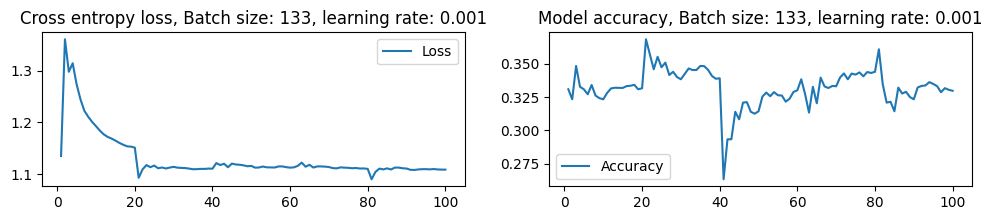

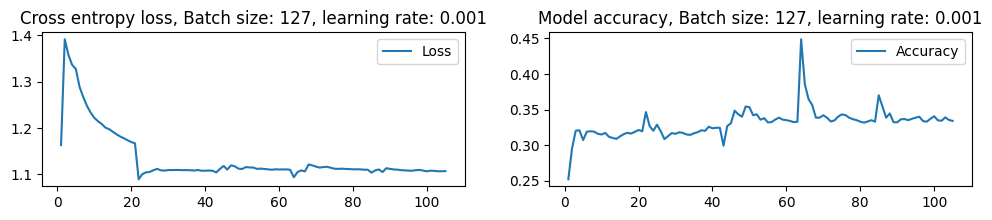

In [ ]:
histories = []
batches_used = []
learning_rates_used = []
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en", sequence_length=195) #does not need to be reinitialized every loop
for i in range(5):
  batch_size = np.random.randint(8, 250)
  learning_rate = np.random.choice([0.01, 0.001, 0.0001, 0.00001, 0.000001])

  train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)
  val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)

  bert_train_set = (train_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

  bert_val_set = (val_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

  classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_en", preprocessor=None, num_classes=3)

  classifier.compile(optimizer=keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

  callback = BCP()
  BCP.batch_accuracy = []
  BCP.batch_loss = []
  history = classifier.fit(bert_train_set, validation_data=bert_val_set, epochs=5, callbacks=[callback])

  figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
  ax1.plot(np.arange(1,len(callback.batch_loss)+1), BCP.batch_loss, label="Loss")
  ax1.set_title("Cross entropy loss, Batch size: "+str(batch_size)+", learning rate: "+str(learning_rate))
  ax1.legend()
  ax2.plot(np.arange(1,len(BCP.batch_accuracy)+1), BCP.batch_accuracy, label="Accuracy")
  ax2.set_title("Model accuracy, Batch size: "+str(batch_size)+", learning rate: "+str(learning_rate))
  ax2.legend()
  batches_used.append(batch_size)
  learning_rates_used.append(learning_rate)
  histories.append(history)


Best batch: 186
Best learning rate: 1e-05
Accuracy: 0.588145911693573


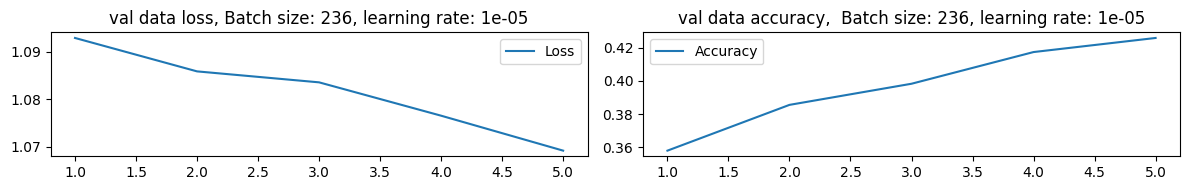

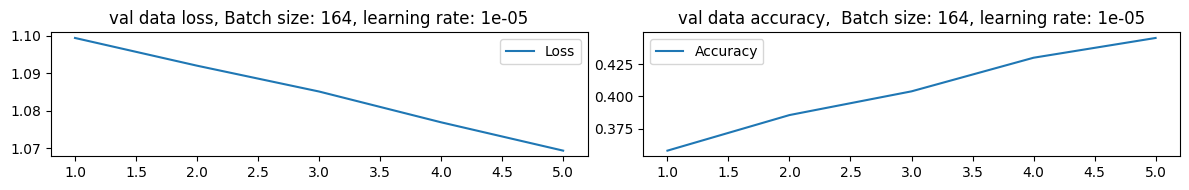

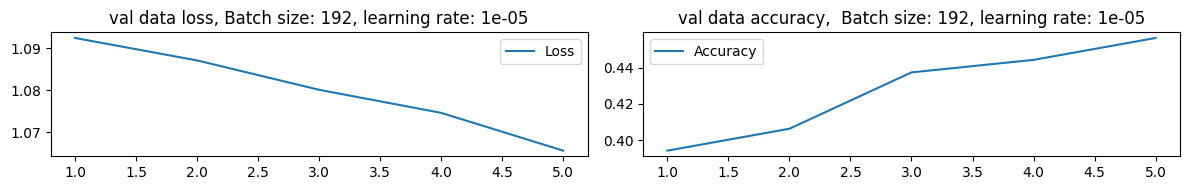

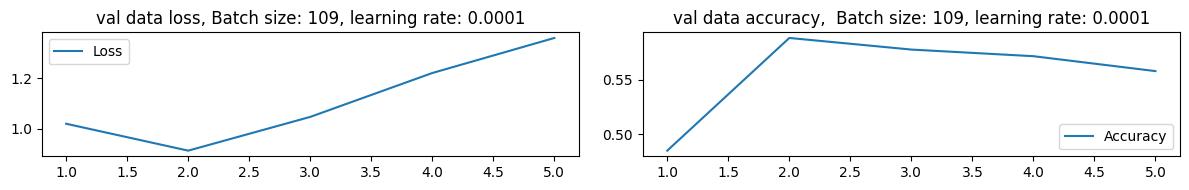

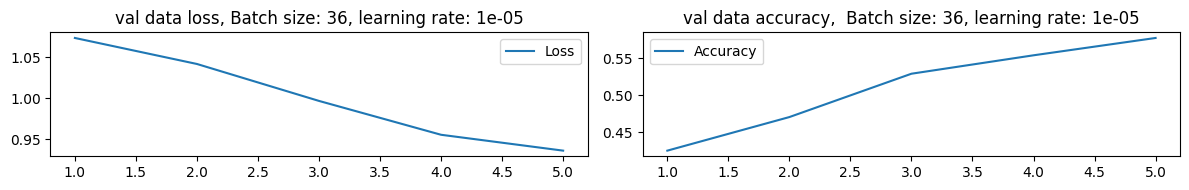

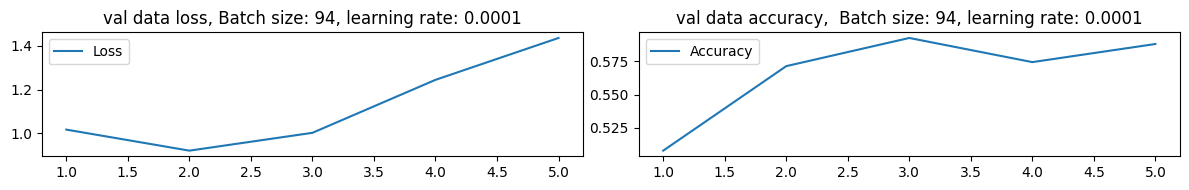

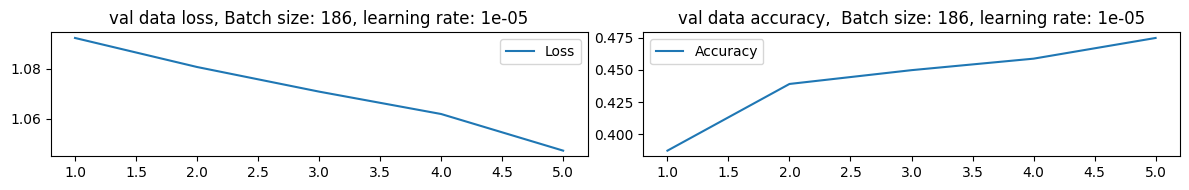

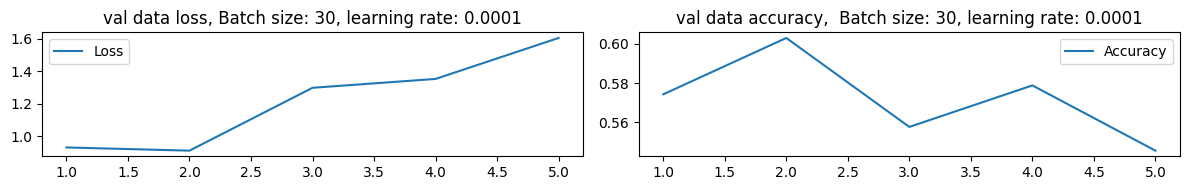

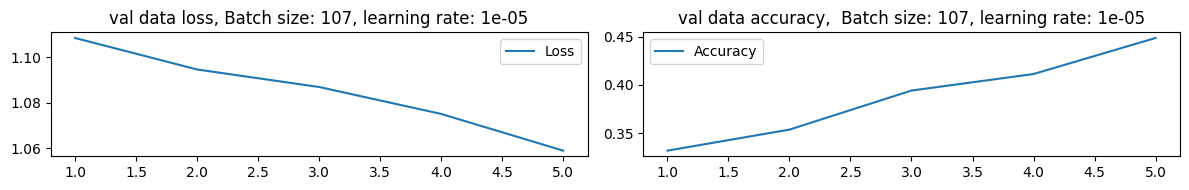

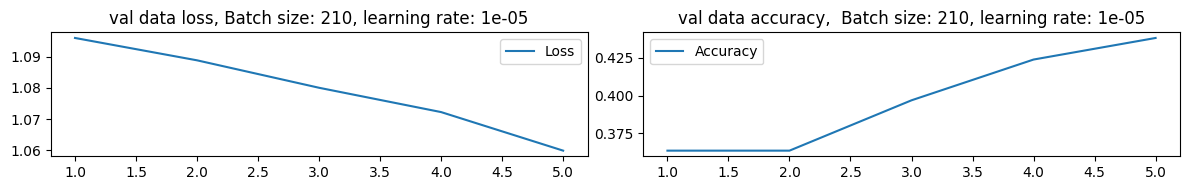

In [53]:
index = 0
best_accuracy = 0
best_batch = 0
best_learning_rate = 0

for i in histories:
  history_dict = i.history
  loss = history_dict["val_loss"]
  acc = history_dict["val_accuracy"]
  figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
  ax1.plot(np.arange(1,len(loss)+1), loss, label="Loss")
  ax1.set_title("val data loss, Batch size: "+str(batches_used[index])+", learning rate: "+str(learning_rates_used[index]))
  ax1.legend()
  ax2.plot(np.arange(1,len(acc)+1), acc, label="Accuracy")
  ax2.set_title("val data accuracy,  Batch size: "+str(batches_used[index])+", learning rate: "+str(learning_rates_used[index]))
  ax2.legend()
  figure.tight_layout()
  index = index + 1
  if acc[-1] > best_accuracy:
    best_accuracy = acc[-1]
    best_batch = batches_used[index]
    best_learning_rate = learning_rates_used[index]

print("Best batch: "+str(best_batch))
print("Best learning rate: "+str(best_learning_rate))
print("Accuracy: "+str(best_accuracy))

### Testing for alternate model sizes, current one is only of layer size 4, we will proceed to test with a 12 layered one. batch size range will be significantly reduced due to possible memory allocation errors

Epoch 1/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 147s 205ms/step - accuracy: 0.3419 - loss: 2.1764 - val_accuracy: 0.3816 - val_loss: 1.1444
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - accuracy: 0.3337 - loss: 1.6266 - val_accuracy: 0.3816 - val_loss: 1.0929
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.3464 - loss: 1.6855 - val_accuracy: 0.3816 - val_loss: 1.3975
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 36s 159ms/step - accuracy: 0.3181 - loss: 1.6039 - val_accuracy: 0.3816 - val_loss: 1.3217
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 36s 159ms/step - accuracy: 0.3276 - loss: 1.6745 - val_accuracy: 0.3816 - val_loss: 1.1415
Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.4032 - loss: 1.0825 - val_accuracy: 0.5497 - val_loss: 0.9546
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 39s 659ms/step - accuracy: 0.6064 - loss: 0.8953 - val_accuracy: 0.5978 - val_loss: 0.8786
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 39s 655ms/step - accuracy: 0.7461 - loss: 0.6468 - val_acc

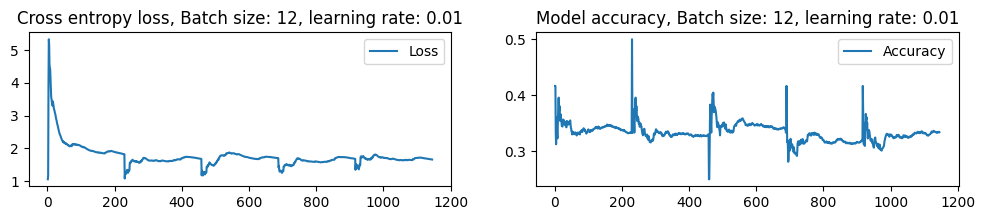

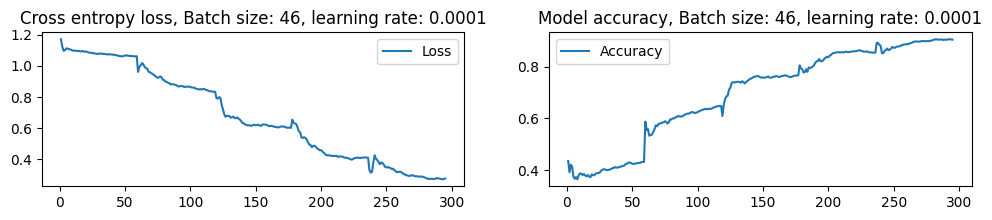

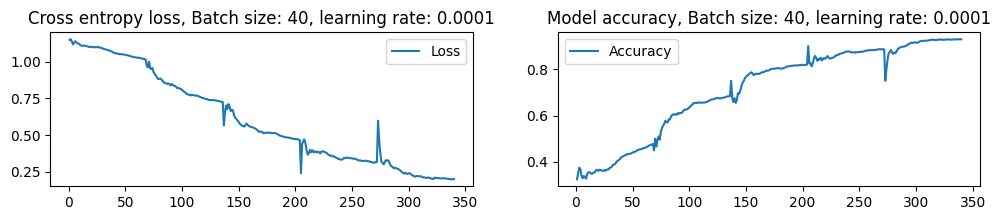

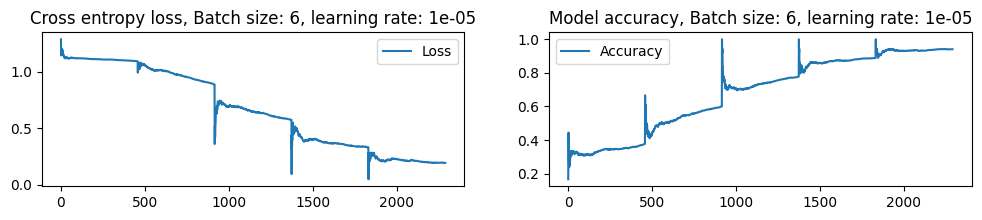

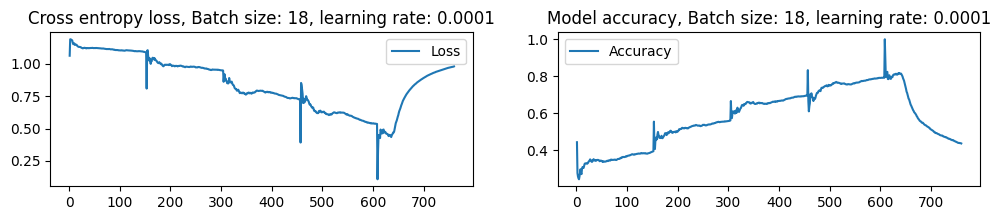

In [9]:
histories = []
batches_used = []
learning_rates_used = []
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en", sequence_length=195) #does not need to be reinitialized every loop
for i in range(5):
  batch_size = np.random.randint(4, 50)
  learning_rate = np.random.choice([0.01, 0.001, 0.0001, 0.00001, 0.000001])

  train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)
  val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)

  bert_train_set = (train_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

  bert_val_set = (val_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

  classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_en", preprocessor=None, num_classes=3)

  classifier.compile(optimizer=keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

  callback = BCP()
  BCP.batch_accuracy = []
  BCP.batch_loss = []
  history = classifier.fit(bert_train_set, validation_data=bert_val_set, epochs=5, callbacks=[callback])

  figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
  ax1.plot(np.arange(1,len(callback.batch_loss)+1), BCP.batch_loss, label="Loss")
  ax1.set_title("Cross entropy loss, Batch size: "+str(batch_size)+", learning rate: "+str(learning_rate))
  ax1.legend()
  ax2.plot(np.arange(1,len(BCP.batch_accuracy)+1), BCP.batch_accuracy, label="Accuracy")
  ax2.set_title("Model accuracy, Batch size: "+str(batch_size)+", learning rate: "+str(learning_rate))
  ax2.legend()
  batches_used.append(batch_size)
  learning_rates_used.append(learning_rate)
  histories.append(history)


Best batch: 6
Best learning rate: 1e-05
Accuracy: 0.6345029473304749


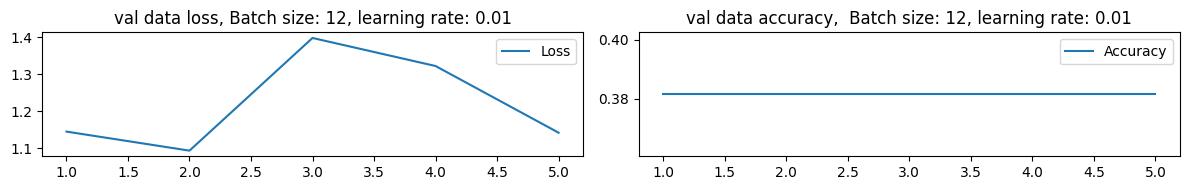

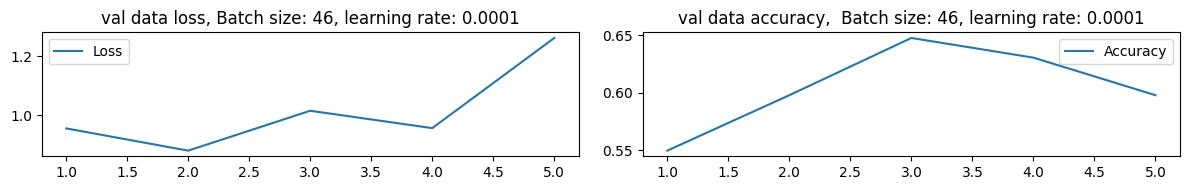

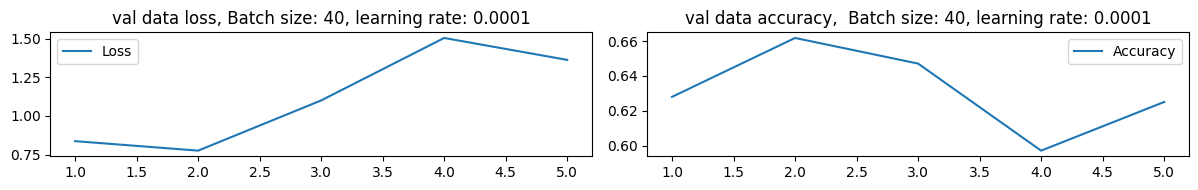

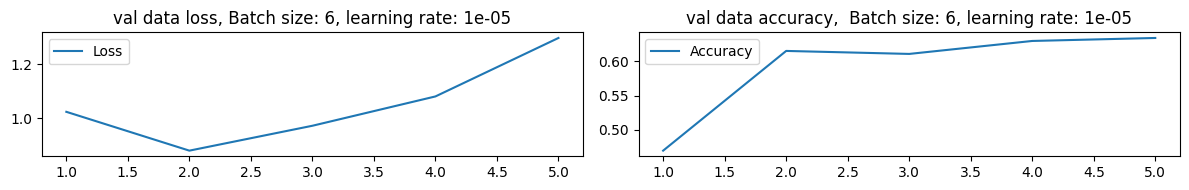

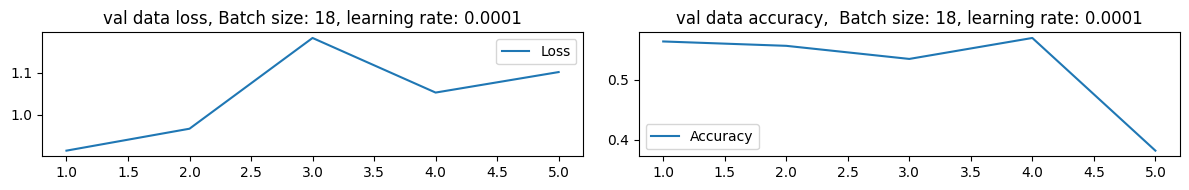

In [14]:
index = 0
best_accuracy = 0
best_batch = 0
best_learning_rate = 0

for i in histories:
  history_dict = i.history
  loss = history_dict["val_loss"]
  acc = history_dict["val_accuracy"]
  figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
  ax1.plot(np.arange(1,len(loss)+1), loss, label="Loss")
  ax1.set_title("val data loss, Batch size: "+str(batches_used[index])+", learning rate: "+str(learning_rates_used[index]))
  ax1.legend()
  ax2.plot(np.arange(1,len(acc)+1), acc, label="Accuracy")
  ax2.set_title("val data accuracy,  Batch size: "+str(batches_used[index])+", learning rate: "+str(learning_rates_used[index]))
  ax2.legend()
  figure.tight_layout()
  if acc[-1] > best_accuracy:
    best_accuracy = acc[-1]
    best_batch = batches_used[index]
    best_learning_rate = learning_rates_used[index]
  index = index + 1

print("Best batch: "+str(best_batch))
print("Best learning rate: "+str(best_learning_rate))
print("Accuracy: "+str(best_accuracy))

- From repeated test, we have come to a decision of placing the adam learning rate around the ranges of 0.00001 and 0.0001

our new learning rate range will be [0.00005, 0.000005]

100%|██████████| 418M/418M [00:27<00:00, 16.1MB/s]


Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 150s 586ms/step - accuracy: 0.3356 - loss: 1.1151 - val_accuracy: 0.4500 - val_loss: 1.0739
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 69s 461ms/step - accuracy: 0.4357 - loss: 1.0487 - val_accuracy: 0.5833 - val_loss: 0.9641
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 452ms/step - accuracy: 0.6303 - loss: 0.8483 - val_accuracy: 0.6227 - val_loss: 0.9133
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - accuracy: 0.7856 - loss: 0.5834 - val_accuracy: 0.6273 - val_loss: 1.0307
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - accuracy: 0.8487 - loss: 0.4428 - val_accuracy: 0.6394 - val_loss: 1.1262
Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 149s 794ms/step - accuracy: 0.3550 - loss: 1.1086 - val_accuracy: 0.4106 - val_loss: 1.0898
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 602ms/step - accuracy: 0.3729 - loss: 1.0925 - val_accuracy: 0.4333 - val_loss: 1.0745
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 604ms/step - accuracy: 0.4228 - loss: 1.0652 - val_accuracy: 

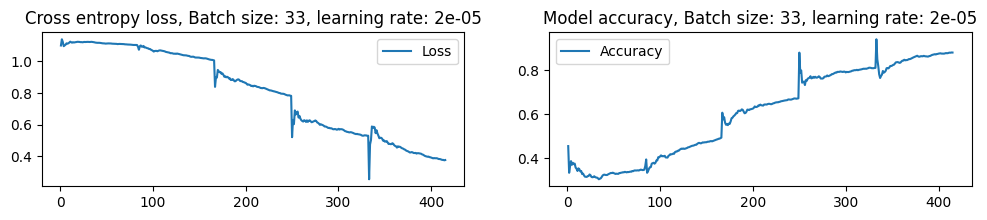

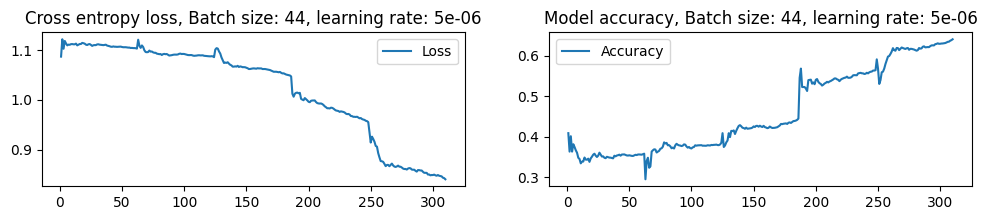

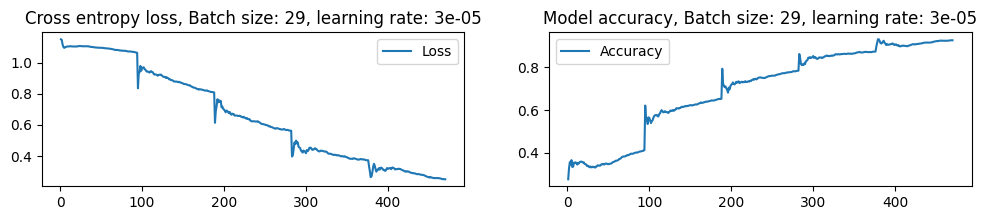

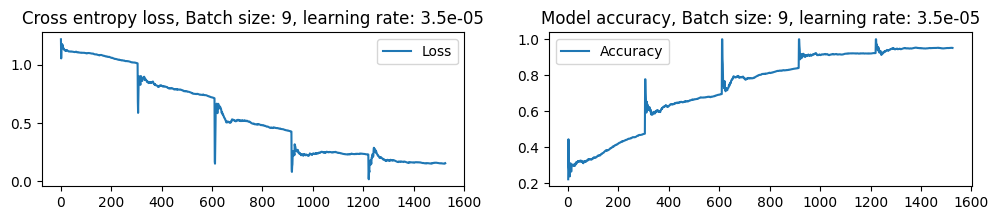

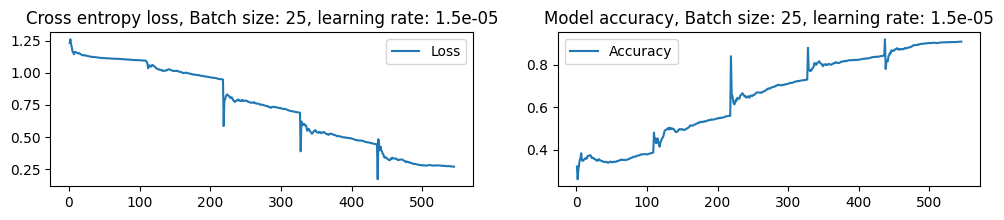

In [9]:
histories = []
batches_used = []
learning_rates_used = []
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en", sequence_length=195) #does not need to be reinitialized every loop
for i in range(5):
  batch_size = np.random.randint(4, 50)
  learning_rate = np.random.randint(1, 10)/200000

  train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)
  val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)

  bert_train_set = (train_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

  bert_val_set = (val_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

  classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_en", preprocessor=None, num_classes=3)

  classifier.compile(optimizer=keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

  callback = BCP()
  BCP.batch_accuracy = []
  BCP.batch_loss = []
  history = classifier.fit(bert_train_set, validation_data=bert_val_set, epochs=5, callbacks=[callback])

  figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
  ax1.plot(np.arange(1,len(callback.batch_loss)+1), BCP.batch_loss, label="Loss")
  ax1.set_title("Cross entropy loss, Batch size: "+str(batch_size)+", learning rate: "+str(learning_rate))
  ax1.legend()
  ax2.plot(np.arange(1,len(BCP.batch_accuracy)+1), BCP.batch_accuracy, label="Accuracy")
  ax2.set_title("Model accuracy, Batch size: "+str(batch_size)+", learning rate: "+str(learning_rate))
  ax2.legend()
  batches_used.append(batch_size)
  learning_rates_used.append(learning_rate)
  histories.append(history)


Best batch: 29
Best learning rate: 3e-05
Accuracy: 0.6686656475067139


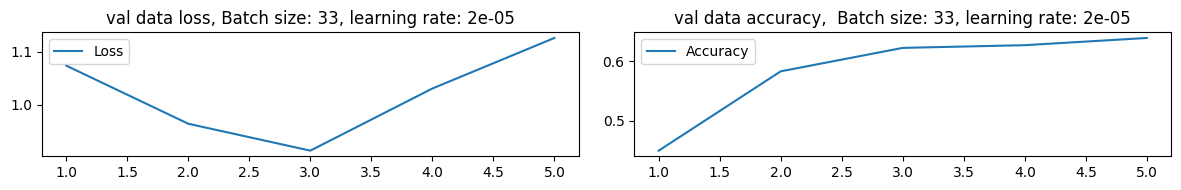

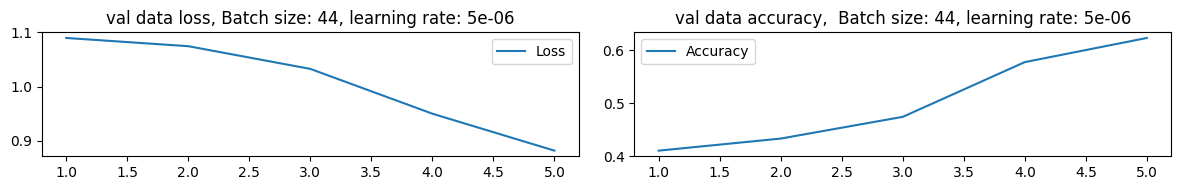

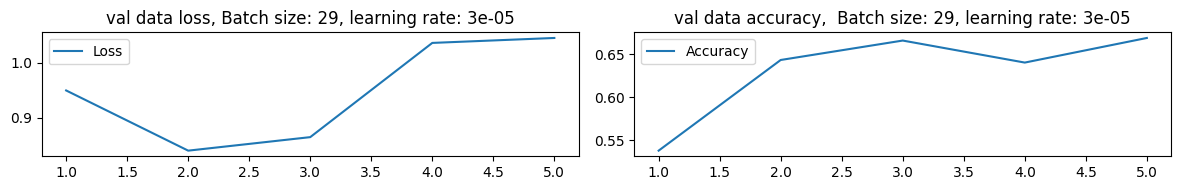

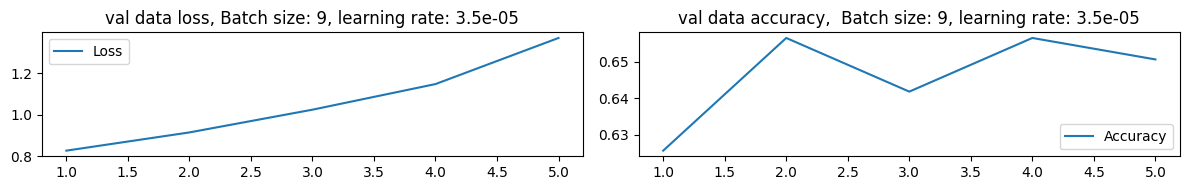

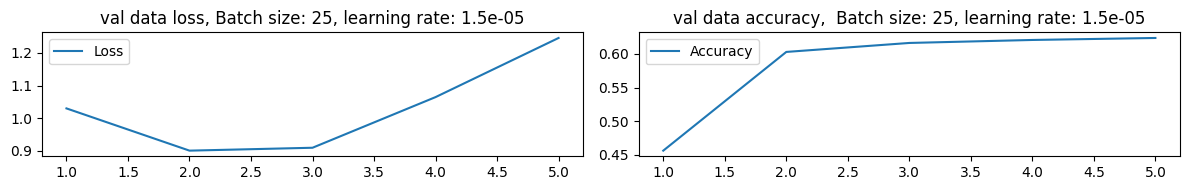

In [10]:
index = 0
best_accuracy = 0
best_batch = 0
best_learning_rate = 0

for i in histories:
  history_dict = i.history
  loss = history_dict["val_loss"]
  acc = history_dict["val_accuracy"]
  figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
  ax1.plot(np.arange(1,len(loss)+1), loss, label="Loss")
  ax1.set_title("val data loss, Batch size: "+str(batches_used[index])+", learning rate: "+str(learning_rates_used[index]))
  ax1.legend()
  ax2.plot(np.arange(1,len(acc)+1), acc, label="Accuracy")
  ax2.set_title("val data accuracy,  Batch size: "+str(batches_used[index])+", learning rate: "+str(learning_rates_used[index]))
  ax2.legend()
  figure.tight_layout()
  if acc[-1] > best_accuracy:
    best_accuracy = acc[-1]
    best_batch = batches_used[index]
    best_learning_rate = learning_rates_used[index]
  index = index + 1

print("Best batch: "+str(best_batch))
print("Best learning rate: "+str(best_learning_rate))
print("Accuracy: "+str(best_accuracy))